In [294]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

## Pima dataset


In this dataset in-total we have been given 9 features out of which, given to us are 8 independent variables and “outcome” attribute is our dependent variable. Among these 8 independent variables, 7 of them has been selected for predicting the outcome. The outcome value as 0 indicates that, person is NOT diabetic AND the outcome value as 1 indicates that, person is very well diabetic. So, the “outcome” for us is a categorical (i.e. Binary) type of variable. 

In [2]:
def get_pima_data():
    col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
    pima = pd.read_csv("data/diabetes.csv", header=None, names=col_names)
    pima.dropna()
    pima = pima.iloc[1:]
    pima.head()

    feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
    pima_X = pima[feature_cols].astype(float) # Features
    pima_y = pima.label.astype(float)
    pima_X.rename(columns = {'pregnant':'f1', 'insulin':'f2', 'bmi':'f3', 'age': 'f4',
                            'glucose': 'f5', 'bp': 'f6', 'pedigree': 'f7'}, inplace = True)
    pima_X = pima_X.head(550)
    pima_y = pima_y.head(550)
    pima_X = pima_X.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))

    return pima_X, pima_y

Also, let’s check the same aforesaid data in terms of percentages of users have Diabetes. Below data indicates that around 35% of users have diabetes and 65% don’t have diabetes.

In [3]:
pima_X, pima_y = get_pima_data()
print(pima_y.value_counts(normalize=True)*100)

0.0    64.545455
1.0    35.454545
Name: label, dtype: float64


## Breast cancer dataset

The breast cancer dataset is a classic and very easy binary classification dataset. Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. There are many features but the ten real-valued features are computed for each cell nucleus are: 
a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)

among these features, seven of them have been selected and the target value is Diagnosis (M = malignant, B = benign).






In [4]:
from sklearn.datasets import load_breast_cancer

def get_cancer_data():
    cancer = load_breast_cancer()
    data = np.c_[cancer.data, cancer.target]
    columns = np.append(cancer.feature_names, ["class"])
    sizeMeasurements = pd.DataFrame(data, columns=columns)
    feature_cols = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                    'mean smoothness','mean compactness','mean symmetry']
    cancer_X = sizeMeasurements[feature_cols].astype(float)
    cancer_y = sizeMeasurements['class'].astype(float)
    cancer_X.rename(columns = {'mean radius':'f1', 'mean texture':'f2', 'mean perimeter':'f3', 'mean area': 'f4',
                            'mean smoothness': 'f5', 'mean compactness': 'f6', 'mean symmetry': 'f7'}, inplace = True)

    cancer_X = cancer_X.head(550)
    cancer_y = cancer_y.head(550)
    cancer_X = cancer_X.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))
    
    return cancer_X, cancer_y

Also, let’s check the same aforesaid data in terms of percentages of users in each class. Below data indicates that around 37% of users are in class 0 and 63% are in class 1.

In [5]:
cancer_X, cancer_y = get_cancer_data()
print(cancer_y.value_counts(normalize=True)*100)

1.0    62.545455
0.0    37.454545
Name: class, dtype: float64


## Create the graph data

Here we have a test dataset that is a comobination of the text datasets from both pima and cancer datasets mentioned above. Additionally, the features for each node of a graph is a random combination of these two datasets. For each node $i$, we first select a random number $r \in [15, 85]$ and then we randomly select $r$% of the pima dataset and $(100-r)$% of the cancer dataset as the train dataset for the node $i$.

Finally, the similarity score between nodes $i$ and $j$ is calculated based on the number of similar datapoint that they have in their training sets.

In [460]:
def get_graph():
    # load Pima dataset
    pima_X, pima_y = get_pima_data()
    
    # load cancer dataset
    cancer_X, cancer_y = get_cancer_data()
    cancer_y = cancer_y.replace(0, 2)
    cancer_y = cancer_y.replace(1, 3)
    
    # split the pima dataset to train and test datasets
    pima_X_train, pima_X_test, pima_y_train, pima_y_test = train_test_split(
        pima_X, pima_y, test_size=0.3, random_state=1) # 70% training and 30% test

    # split the cancer dataset to train and test datasets
    cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(
        cancer_X, cancer_y, test_size=0.3, random_state=1) # 70% training and 30% test    
    
    
    # combine the pima and cancer test datasets
    X_test = pd.concat((pima_X_test, cancer_X_test))
    y_test = pd.concat((pima_y_test, cancer_y_test))
    

    # 
    data_len = len(pima_X_train)
    datapoints = {}
    N = 20
    node_indices = []
    for n in range(N):
        # select a random number  0.25 < r < 0.75
        r = random.random()
        while r < 0.15 or r > 0.85:
            r = random.random()
            
        # uniformly select r% of the data from pima dataset
        node_idx1 = random.sample([i for i in range(data_len)], int(data_len*r)) 
        node_pima_x = pima_X_train.iloc[node_idx1]
        node_pima_y = pima_y_train.iloc[node_idx1].values
        
        # uniformly select (1-r)% of the data from cancer dataset
        node_idx2 = random.sample([i for i in range(data_len)], int(data_len*(1-r))) 
        node_cancer_x = cancer_X_train.iloc[node_idx2]
        node_cancer_y = cancer_y_train.iloc[node_idx2].values
        
        
        node_indices.append((node_idx1, node_idx2))
        datapoints[n] = {
            'features': pd.concat((node_pima_x, node_cancer_x)),
            'all_features': pd.concat((node_pima_x, node_cancer_x)),
            'labels': np.concatenate((node_pima_y, node_cancer_y)),
            'all_labels': np.concatenate((node_pima_y, node_cancer_y)),
            'sample_weights': np.ones(len(node_idx1)+len(node_idx2)),
            'model': DecisionTreeClassifier(),
        }

        
    # calculate the similarities between nodes
    E = N * (N-1)//2
    B = np.zeros((E, N))
    weight_vec = np.zeros(E)
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            data_len = len(node_indices[i][0]) + len(node_indices[i][1])
#             w1 = len(node_indices[i][0]) - len(set(node_indices[i][0]) - set(node_indices[j][0]))
#             w2 = len(node_indices[i][1]) - len(set(node_indices[i][1]) - set(node_indices[j][1]))
            
            w1 = min(len(node_indices[i][0]), len(node_indices[j][0]))
            w2 = min(len(node_indices[i][1]), len(node_indices[j][1]))
            weight_vec[cnt] = (w1 + w2)/data_len
            B[cnt, i] = 1
            B[cnt, j] = -1
            cnt += 1
            
    return B, weight_vec, datapoints, X_test, y_test

            


In [461]:
# def get_graph():
#     # load Pima dataset
#     pima_X, pima_y = get_pima_data()
    
#     # load cancer dataset
#     cancer_X, cancer_y = get_cancer_data()
#     cancer_y = cancer_y.replace(0, 2)
#     cancer_y = cancer_y.replace(1, 3)
    
#     # split the pima dataset to train and test datasets
#     pima_X_train, pima_X_test, pima_y_train, pima_y_test = train_test_split(
#         pima_X, pima_y, test_size=0.05, random_state=1) # 70% training and 30% test

#     # split the cancer dataset to train and test datasets
#     cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(
#         cancer_X, cancer_y, test_size=0.05, random_state=1) # 70% training and 30% test    
    
    
#     # combine the pima and cancer test datasets
#     X_test = pd.concat((pima_X_test, cancer_X_test))
#     y_test = pd.concat((pima_y_test, cancer_y_test))
    

#     # 
#     data_len = len(pima_X_train)
#     datapoints = {}
#     N = 20
#     node_indices = []
#     for n in range(N):
#         # select a random number  0.25 < r < 0.75
#         r = random.random()
#         while r < 0.15 or r > 0.85:
#             r = random.random()
            
#         # uniformly select r% of the data from pima dataset
#         node_idx1 = random.sample([i for i in range(data_len)], int(data_len*r)) 
#         node_pima_x = pima_X_train.iloc[node_idx1]
#         node_pima_y = pima_y_train.iloc[node_idx1].values
#         node_pima_x_train, node_pima_x_test, node_pima_y_train, node_pima_y_test = train_test_split(
#         node_pima_x, node_pima_y, test_size=0.1, random_state=1)
        
#         # uniformly select (1-r)% of the data from cancer dataset
#         node_idx2 = random.sample([i for i in range(data_len)], int(data_len*(1-r))) 
#         node_cancer_x = cancer_X_train.iloc[node_idx2]
#         node_cancer_y = cancer_y_train.iloc[node_idx2].values
#         node_cancer_x_train, node_cancer_x_test, node_cancer_y_train, node_cancer_y_test = train_test_split(
#         node_cancer_x, node_cancer_y, test_size=0.1, random_state=1)
        
        
#         node_indices.append((node_idx1, node_idx2))
#         datapoints[n] = {
#             'features': pd.concat((node_pima_x_train, node_cancer_x_train)),
#             'val_features': pd.concat((node_pima_x_test, node_cancer_x_test)),
#             'all_features': pd.concat((node_pima_x, node_cancer_x)),
#             'labels': np.concatenate((node_pima_y_train, node_cancer_y_train)),
#             'val_labels': np.concatenate((node_pima_y_test, node_cancer_y_test)),
#             'all_labels': np.concatenate((node_pima_y, node_cancer_y)),
#             'sample_weights': np.ones(len(node_idx1)+len(node_idx2)),
#             'model': DecisionTreeClassifier(),
#         }

        
#     # calculate the similarities between nodes
#     E = N * (N-1)//2
#     B = np.zeros((E, N))
#     weight_vec = np.zeros(E)
#     cnt = 0
#     for i in range(N):
#         for j in range(N):
#             if j <= i:
#                 continue
#             data_len = len(node_indices[i][0]) + len(node_indices[i][1])
# #             w1 = len(node_indices[i][0]) - len(set(node_indices[i][0]) - set(node_indices[j][0]))
# #             w2 = len(node_indices[i][1]) - len(set(node_indices[i][1]) - set(node_indices[j][1]))
            
#             w1 = min(len(node_indices[i][0]), len(node_indices[j][0]))
#             w2 = min(len(node_indices[i][1]), len(node_indices[j][1]))
#             weight_vec[cnt] = (w1 + w2)/data_len
#             B[cnt, i] = 1
#             B[cnt, j] = -1
#             cnt += 1
            
#     return B, weight_vec, datapoints, X_test, y_test

            


## Algorithm


In [462]:
def algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=1.0, K=100):
    test_len = len(X_test)
    
    iter_scores = []
    for k in range(K):
        
        # fit the model for each node
        for node in datapoints:
            clf = datapoints[node]['model']
            clf = clf.fit(datapoints[node]['all_features'], datapoints[node]['all_labels'], 
                          sample_weight=datapoints[node]['sample_weights'])
            datapoints[node]['model'] = clf

        # calculate the accuracy for each node
        accs = []
        for node in datapoints:
            clf = datapoints[node]['model']
            y_pred = clf.predict(X_test)
            accs.append(metrics.accuracy_score(y_test, y_pred))
        iter_scores.append(accs)

        # combine the test predictions for the adjancents node of each node
        for node in datapoints:
            datapoints[node]['all_features'] = [datapoints[node]['features']]
            datapoints[node]['all_labels'] = datapoints[node]['labels']
            datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['labels']))
            for B_neigh in np.where(B[:, node] != 0)[0]:
                w = weight_vec[B_neigh]
                for neigh in np.where(B[B_neigh, :] != 0)[0]:
                    if neigh == node:
                        continue
                    data_idx = random.sample([i for i in range(test_len)], int(test_len*w)) 
                    selected_x_test = X_test.iloc[data_idx]
                    datapoints[node]['all_features'].append(selected_x_test)
                    y_pred = datapoints[neigh]['model'].predict(selected_x_test)
                    datapoints[node]['all_labels'] = np.concatenate(
                        (datapoints[node]['all_labels'], y_pred))
                    _sample_weights = [lambda_lasso/2.0 for _ in range(len(y_pred))]
                    datapoints[node]['sample_weights'] = np.concatenate(
                        (datapoints[node]['sample_weights'], _sample_weights))

            datapoints[node]['all_features'] = pd.concat(datapoints[node]['all_features'])

    iter_scores = np.array(iter_scores)
    
    return iter_scores

In [463]:
# def algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=1.0, K=100):
#     test_len = len(X_test)
    
#     iter_scores = []
#     for k in range(K):
        
#         # fit the model for each node
#         for node in datapoints:
#             clf = datapoints[node]['model']
#             clf = clf.fit(datapoints[node]['all_features'], datapoints[node]['all_labels'], 
#                           sample_weight=datapoints[node]['sample_weights'])
#             datapoints[node]['model'] = clf

#         # calculate the accuracy for each node
#         accs = []
#         for node in datapoints:
#             clf = datapoints[node]['model']
# #             y_pred = clf.predict(datapoints[node]['val_features'])
# #             accs.append(metrics.accuracy_score(datapoints[node]['val_labels'], y_pred))
#             y_pred = clf.predict(datapoints[node]['val_features'])
#             y_pred1 = clf.predict(X_test)
#             accs.append(metrics.accuracy_score(np.concatenate((datapoints[node]['val_labels'], y_test)), 
#                                                np.concatenate((y_pred,y_pred1))))
#         iter_scores.append(accs)

#         # combine the test predictions for the adjancents node of each node
#         for node in datapoints:
#             datapoints[node]['all_features'] = [datapoints[node]['features']]
#             datapoints[node]['all_labels'] = datapoints[node]['labels']
#             datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['labels']))
#             for B_neigh in np.where(B[:, node] != 0)[0]:
#                 w = weight_vec[B_neigh]
#                 for neigh in np.where(B[B_neigh, :] != 0)[0]:
#                     if neigh == node:
#                         continue
#                     data_idx = random.sample([i for i in range(test_len)], int(test_len*w)) 
#                     selected_x_test = X_test.iloc[data_idx]
#                     datapoints[node]['all_features'].append(selected_x_test)
#                     y_pred = datapoints[neigh]['model'].predict(selected_x_test)
#                     datapoints[node]['all_labels'] = np.concatenate(
#                         (datapoints[node]['all_labels'], y_pred))
#                     _sample_weights = [lambda_lasso/2.0 for _ in range(len(y_pred))]
#                     datapoints[node]['sample_weights'] = np.concatenate(
#                         (datapoints[node]['sample_weights'], _sample_weights))

#             datapoints[node]['all_features'] = pd.concat(datapoints[node]['all_features'])

#     iter_scores = np.array(iter_scores)
    
#     return iter_scores

In [469]:
B, weight_vec, datapoints, X_test, y_test = get_graph()

K = 50
# federated learning accuracies
iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=1.0, K=K)

# Individual accuracies
for node in datapoints:
    datapoints[node]['model'] = DecisionTreeClassifier()

single_iter_scores = []
for k in range(K):
    for node in datapoints:
        clf = datapoints[node]['model']
        clf = clf.fit(datapoints[node]['features'], datapoints[node]['labels'])
        datapoints[node]['model'] = clf
        
    accs = []
    for node in datapoints:
        clf = datapoints[node]['model']
#         y_pred = clf.predict(datapoints[node]['val_features'])
        y_pred1 = clf.predict(X_test)
#         accs.append(metrics.accuracy_score(np.concatenate((datapoints[node]['val_labels'], y_test)), 
#                                            np.concatenate((y_pred,y_pred1))))
        accs.append(metrics.accuracy_score(y_test, y_pred1))
    single_iter_scores.append(accs)
    
    
single_iter_scores = np.array(single_iter_scores)


In [470]:
len(datapoints[0]['all_features']), len(datapoints[0]['features']), len(X_test)

(5426, 384, 330)

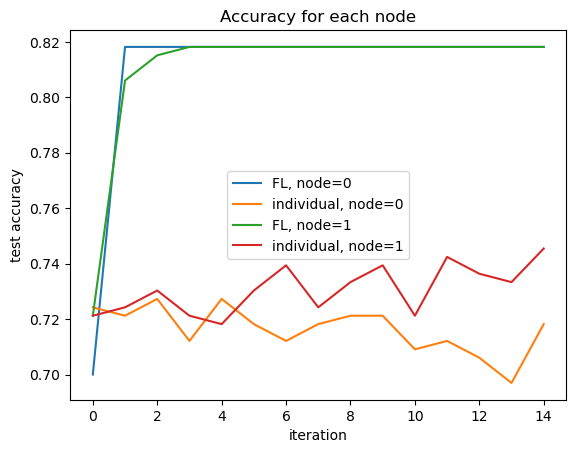

In [471]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for node in datapoints:
    plt.plot(x, iter_scores[:, node][:len(x)], label='FL, node=' + str(node))
    plt.plot(x, single_iter_scores[:, node][:len(x)], label='individual, node=' + str(node))
    if node > 0:
        break
plt.title('Accuracy for each node')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
plt.close()

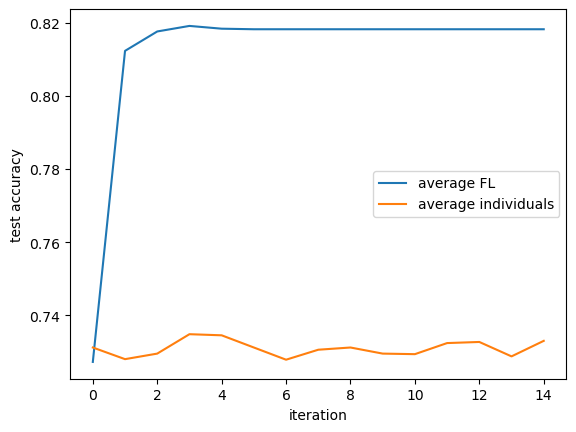

In [473]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
fl_mean_acc = np.mean(iter_scores, axis=1)[:len(x)]
single_mean_acc = np.mean(single_iter_scores, axis=1)[:len(x)]
plt.plot(x, fl_mean_acc, label='average FL')
plt.plot(x, single_mean_acc, label='average individuals')

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
f.savefig("./data/non-parametric/fl_vs_individual.pdf", bbox_inches='tight')
plt.close()

In [476]:
fl_vs_individual_data = {
    'fl_mean_acc': list(fl_mean_acc),
    'individual_mean_acc': list(single_mean_acc),
}

import pandas as pd
  
data = [[i, fl_mean_acc[i], single_mean_acc[i]] for i in range(15)]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['iter', 'fl_mean', 'individual_mean'])

with open('./data/non-parametric/fl_vs_individual.json', 'w') as f:
    f.write(json.dumps(fl_vs_individual_data))
    
df.to_csv('./data/non-parametric/fl_vs_individual.csv')

In [303]:
B, weight_vec, datapoints, X_test, y_test = get_graph()

In [170]:

K = 20
# federated learning accuracies
lambda_lasso_scores = {}
lambda_lassos = [0.01, 0.1, 1.0, 10.0]
for lambda_lasso in lambda_lassos:
    for node in datapoints:
        datapoints[node]['model'] = DecisionTreeClassifier()
        datapoints[node]['all_features'] = datapoints[node]['features']
        datapoints[node]['all_labels'] = datapoints[node]['labels']
        datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['all_features']))

    iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=lambda_lasso, K=K)
    lambda_lasso_scores[lambda_lasso] = np.array(iter_scores)

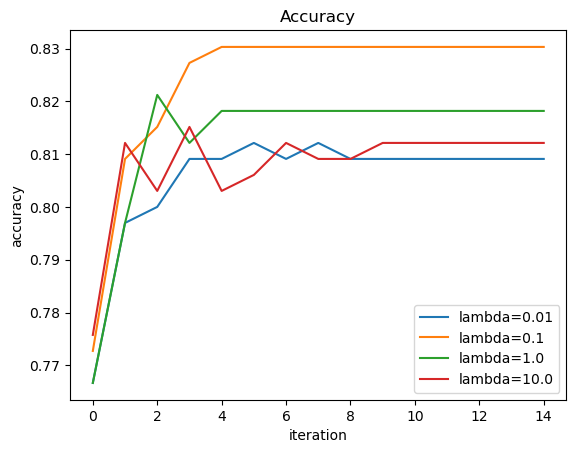

In [173]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    node = 0
    plt.plot(x, lambda_lasso_scores[lambda_lasso][:, node][:len(x)], label='lambda=' + str(lambda_lasso))
plt.title('Accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
f.savefig("./data/non-parametric/lambda.pdf", bbox_inches='tight')
plt.close()

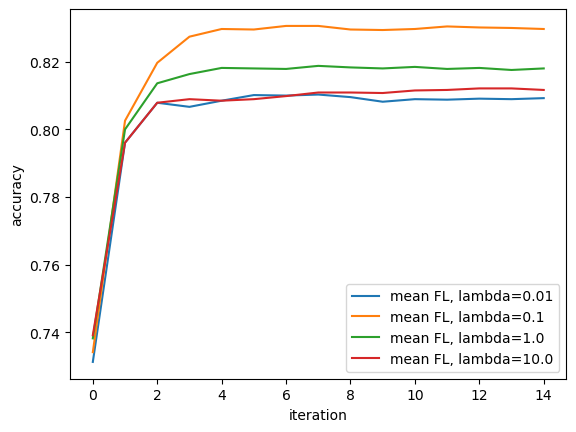

In [174]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=1)[:len(x)]
    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
f.savefig("./data/non-parametric/mean_lambda.pdf", bbox_inches='tight')
plt.close()

In [175]:
import json

for lambda_lasso in lambda_lasso_scores:
    lambda_lasso_scores[lambda_lasso] = lambda_lasso_scores[lambda_lasso].tolist()

with open('./data/non-parametric/lambda_lasso_scores.json', 'w') as f:
    f.write(json.dumps(lambda_lasso_scores))

In [176]:
def get_sbm_graph():
    # load Pima dataset
    pima_X, pima_y = get_pima_data()
    
    # load cancer dataset
    cancer_X, cancer_y = get_cancer_data()
    cancer_y = cancer_y.replace(0, 2)
    cancer_y = cancer_y.replace(1, 3)
    
    # split the pima dataset to train and test datasets
    pima_X_train, pima_X_test, pima_y_train, pima_y_test = train_test_split(
        pima_X, pima_y, test_size=0.3, random_state=1) # 70% training and 30% test

    # split the cancer dataset to train and test datasets
    cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(
        cancer_X, cancer_y, test_size=0.3, random_state=1) # 70% training and 30% test    
    
    
    # combine the pima and cancer test datasets
    X_test = pd.concat((pima_X_test, cancer_X_test))
    y_test = pd.concat((pima_y_test, cancer_y_test))
    

    # 
    data_len = len(pima_X_train)
    datapoints = {}
    N = 20
    node_indices = []
    for n in range(N):
        # select a random number  0.25 < r < 0.75
        r = random.random()/2
        while r < 0.15 or r > 0.35:
            r = random.random()
            
        # uniformly select r% of the data from pima dataset
        if n < N//2:
            r += 0.5
            
        node_idx1 = random.sample([i for i in range(data_len)], int(data_len*r)) 
        node_pima_x = pima_X_train.iloc[node_idx1]
        node_pima_y = pima_y_train.iloc[node_idx1].values
        
        # uniformly select (1-r)% of the data from cancer dataset
        node_idx2 = random.sample([i for i in range(data_len)], int(data_len*(1-r))) 
        node_cancer_x = cancer_X_train.iloc[node_idx2]
        node_cancer_y = cancer_y_train.iloc[node_idx2].values
        
        node_indices.append((node_idx1, node_idx2))
        datapoints[n] = {
            'features': pd.concat((node_pima_x, node_cancer_x)),
            'all_features': pd.concat((node_pima_x, node_cancer_x)),
            'labels': np.concatenate((node_pima_y, node_cancer_y)),
            'all_labels': np.concatenate((node_pima_y, node_cancer_y)),
            'sample_weights': np.ones(len(node_idx1)+len(node_idx2)),
            'model': DecisionTreeClassifier(),
        }

        
    # calculate the similarities between nodes
    E = N * (N-1)//2
    B = np.zeros((E, N))
    weight_vec = np.zeros(E)
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            data_len = len(node_indices[i][0]) + len(node_indices[i][1])
#             w1 = len(node_indices[i][0]) - len(set(node_indices[i][0]) - set(node_indices[j][0]))
#             w2 = len(node_indices[i][1]) - len(set(node_indices[i][1]) - set(node_indices[j][1]))
#             weight_vec[cnt] = (w1 + w2)/data_len
            weight_vec[cnt] = min(len(node_indices[i][0]), len(node_indices[j][0]))/data_len
            B[cnt, i] = 1
            B[cnt, j] = -1
            cnt += 1
            
    return B, weight_vec, datapoints, X_test, y_test

            


In [185]:
B, weight_vec, datapoints, X_test, y_test = get_sbm_graph()

In [223]:

K = 20
# federated learning accuracies
lambda_lasso_scores = {}
lambda_lassos = [0.01, 0.1, 1.0, 10.0]
for lambda_lasso in lambda_lassos:
    for node in datapoints:
        datapoints[node]['model'] = DecisionTreeClassifier()
        datapoints[node]['all_features'] = datapoints[node]['features']
        datapoints[node]['all_labels'] = datapoints[node]['labels']
        datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['all_features']))

    iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=lambda_lasso, K=K)
    lambda_lasso_scores[lambda_lasso] = np.array(iter_scores)

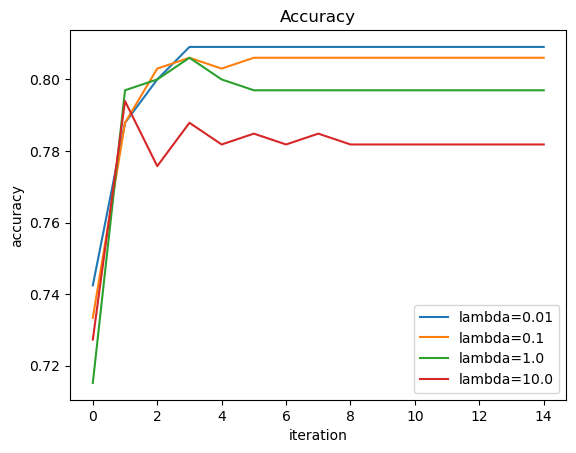

In [224]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    node = 0
    plt.plot(x, lambda_lasso_scores[lambda_lasso][:, node][:len(x)], label='lambda=' + str(lambda_lasso))
plt.title('Accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_lambda.pdf", bbox_inches='tight')
plt.close()

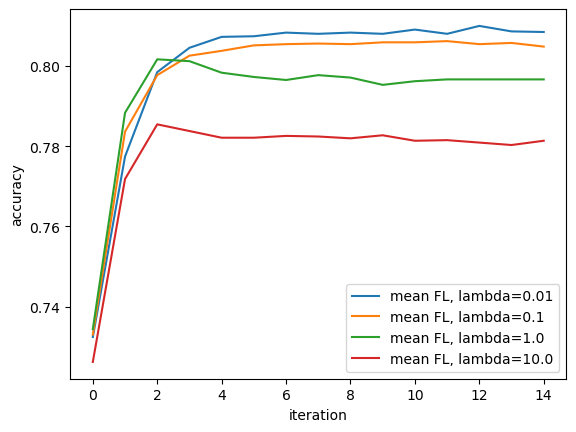

In [225]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=1)[:len(x)]
    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

In [226]:
import json

for lambda_lasso in lambda_lasso_scores:
    lambda_lasso_scores[lambda_lasso] = lambda_lasso_scores[lambda_lasso].tolist()

with open('./data/non-parametric/sbm_lambda_lasso_scores.json', 'w') as f:
    f.write(json.dumps(lambda_lasso_scores))

In [272]:
B, weight_vec, datapoints, X_test, y_test = get_graph()

weight_vec = np.ones(len(weight_vec))

In [273]:

K = 20
# federated learning accuracies
lambda_lasso_scores = {}
lambda_lassos = [0.01, 1.0, 100.0]
for lambda_lasso in lambda_lassos:
    lambda_lasso_scores[lambda_lasso] = np.zeros((10, K))
    for i in range(10):
        for node in datapoints:
            datapoints[node]['model'] = DecisionTreeClassifier()
            datapoints[node]['all_features'] = datapoints[node]['features']
            datapoints[node]['all_labels'] = datapoints[node]['labels']
            datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['all_features']))

        iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=lambda_lasso, K=K)
        lambda_lasso_scores[lambda_lasso][i, :] = np.mean(np.array(iter_scores), axis=1)

0.01 [0.81618182 0.81636364 0.81636364 0.81636364 0.81636364 0.81636364
 0.81636364 0.81636364 0.81636364 0.81636364 0.81636364 0.81636364
 0.81636364 0.81636364 0.81636364]
1.0 [0.73916667 0.80863636 0.80909091 0.80909091 0.80909091 0.80909091
 0.80909091 0.80909091 0.80909091 0.80909091 0.80909091 0.80909091
 0.80909091 0.80909091 0.80909091]
100.0 [0.73865152 0.80818182 0.80818182 0.80818182 0.80818182 0.80818182
 0.80818182 0.80818182 0.80818182 0.80818182 0.80818182 0.80818182
 0.80818182 0.80818182 0.80818182]


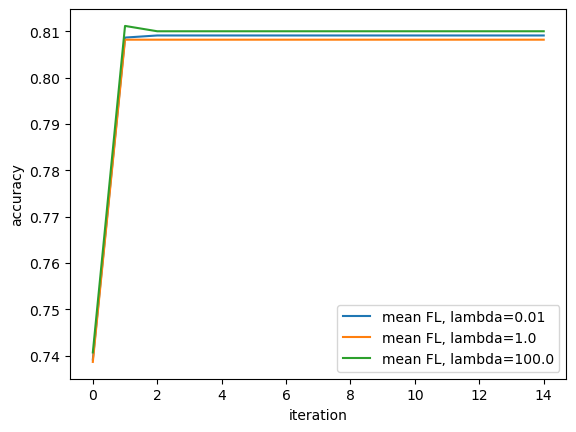

In [274]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    print(lambda_lasso, fl_mean_acc)
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=0)[:len(x)]

    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

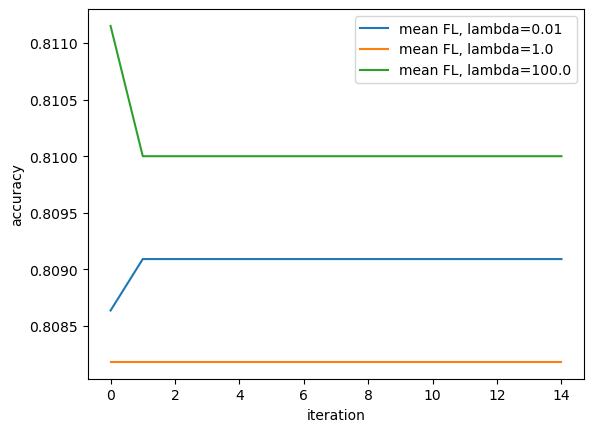

In [275]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=0)[1:len(x)+1]

    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

In [276]:

K = 20
# federated learning accuracies
lambda_lasso_scores = {}
lambda_lassos = [0.01, 1.0, 100.0]
for lambda_lasso in lambda_lassos:
    lambda_lasso_scores[lambda_lasso] = np.zeros((10, K))
    for i in range(10):
        for node in datapoints:
            datapoints[node]['model'] = DecisionTreeClassifier()
            datapoints[node]['all_features'] = datapoints[node]['features']
            datapoints[node]['all_labels'] = datapoints[node]['labels']
            datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['all_features']))

        iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=lambda_lasso, K=K)
        lambda_lasso_scores[lambda_lasso][i, :] = np.mean(np.array(iter_scores), axis=1)

0.01 [0.81115152 0.81       0.81       0.81       0.81       0.81
 0.81       0.81       0.81       0.81       0.81       0.81
 0.81       0.81       0.81      ]
1.0 [0.7389697  0.80983333 0.81030303 0.81030303 0.81030303 0.81030303
 0.81030303 0.81030303 0.81030303 0.81030303 0.81030303 0.81030303
 0.81030303 0.81030303 0.81030303]
100.0 [0.7375303  0.80812121 0.80833333 0.80833333 0.80833333 0.80833333
 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333
 0.80833333 0.80833333 0.80833333]


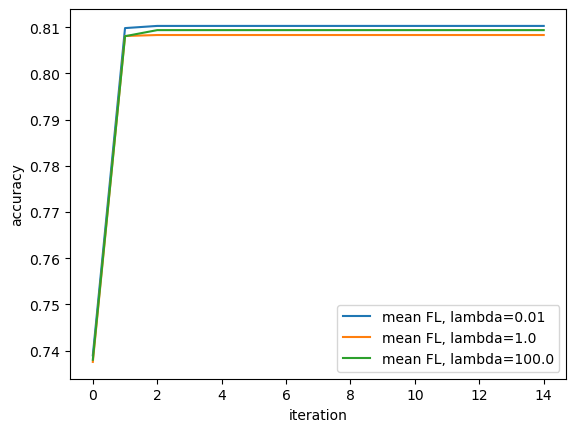

In [277]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    print(lambda_lasso, fl_mean_acc)
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=0)[:len(x)]

    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

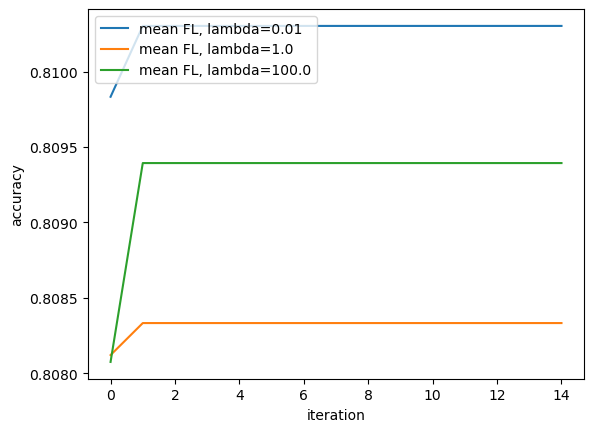

In [278]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=0)[1:len(x)+1]

    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

In [288]:
B, weight_vec, datapoints, X_test, y_test = get_graph()

In [289]:

K = 20
# federated learning accuracies
lambda_lasso_scores = {}
lambda_lassos = [0.01, 0.1, 1.0, 10.0]
for lambda_lasso in lambda_lassos:
    lambda_lasso_scores[lambda_lasso] = np.zeros((10, K))
    for i in range(10):
        for node in datapoints:
            datapoints[node]['model'] = DecisionTreeClassifier()
            datapoints[node]['all_features'] = datapoints[node]['features']
            datapoints[node]['all_labels'] = datapoints[node]['labels']
            datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['all_features']))

        iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=lambda_lasso, K=K)
        lambda_lasso_scores[lambda_lasso][i, :] = np.mean(np.array(iter_scores), axis=1)

0.01 [0.73812121 0.80784848 0.80757576 0.80757576 0.80757576 0.80757576
 0.80757576 0.80757576 0.80757576 0.80757576 0.80757576 0.80757576
 0.80757576 0.80757576 0.80757576]
0.1 [0.73713636 0.78677273 0.79875758 0.80081818 0.80134848 0.80139394
 0.8014697  0.80148485 0.80168182 0.80139394 0.80133333 0.80133333
 0.80122727 0.80136364 0.80121212]
1.0 [0.73719697 0.78609091 0.79842424 0.80116667 0.80230303 0.80189394
 0.80193939 0.80181818 0.80189394 0.80201515 0.80192424 0.80186364
 0.80189394 0.80210606 0.80180303]
10.0 [0.7385     0.78577273 0.7975     0.8        0.80083333 0.80136364
 0.80134848 0.80139394 0.80140909 0.80131818 0.80133333 0.80110606
 0.80131818 0.80122727 0.80127273]


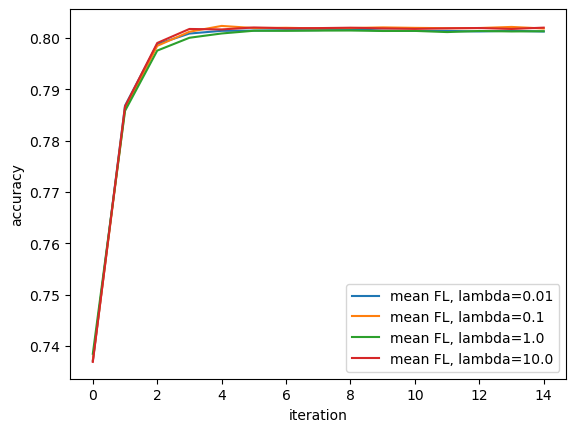

In [290]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    print(lambda_lasso, fl_mean_acc)
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=0)[:len(x)]

    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

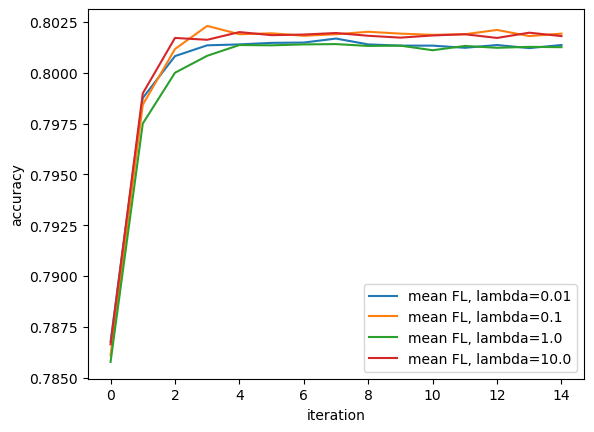

In [291]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=0)[1:len(x)+1]

    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

In [292]:

K = 20
# federated learning accuracies
lambda_lasso_scores = {}
lambda_lassos = [0.01, 0.1, 1.0, 10.0]
for lambda_lasso in lambda_lassos:
    lambda_lasso_scores[lambda_lasso] = np.zeros((10, K))
    for i in range(10):
        for node in datapoints:
            datapoints[node]['model'] = DecisionTreeClassifier()
            datapoints[node]['all_features'] = datapoints[node]['features']
            datapoints[node]['all_labels'] = datapoints[node]['labels']
            datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['all_features']))

        iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=lambda_lasso, K=K)
        lambda_lasso_scores[lambda_lasso][i, :] = np.mean(np.array(iter_scores), axis=1)

0.01 [0.78663636 0.79898485 0.80171212 0.80162121 0.802      0.80184848
 0.80187879 0.80195455 0.80181818 0.80172727 0.80183333 0.80189394
 0.80171212 0.8019697  0.80180303]
0.1 [0.73771212 0.78493939 0.79672727 0.79901515 0.80007576 0.79978788
 0.7995     0.7995     0.79931818 0.7994697  0.79959091 0.79951515
 0.79921212 0.79966667 0.79965152]
1.0 [0.73595455 0.786      0.79733333 0.79874242 0.79848485 0.79880303
 0.79827273 0.79790909 0.79792424 0.79804545 0.79804545 0.79787879
 0.79821212 0.79792424 0.79801515]
10.0 [0.73698485 0.78665152 0.80062121 0.80360606 0.80425758 0.80415152
 0.80427273 0.80415152 0.8039697  0.804      0.8040303  0.80383333
 0.80424242 0.80395455 0.80410606]


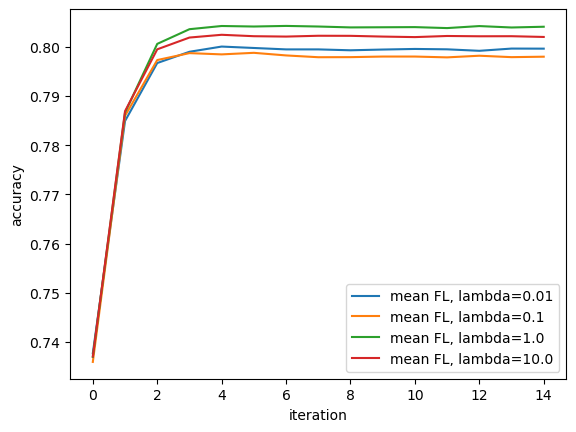

In [293]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    print(lambda_lasso, fl_mean_acc)
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=0)[:len(x)]

    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()

In [247]:

K = 20
# federated learning accuracies
lambda_lasso_scores = {}
lambda_lassos = [0.01, 1.0, 100.0]
fo i in range(5)
for lambda_lasso in lambda_lassos:
    for node in datapoints:
        datapoints[node]['model'] = DecisionTreeClassifier()
        datapoints[node]['all_features'] = datapoints[node]['features']
        datapoints[node]['all_labels'] = datapoints[node]['labels']
        datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['all_features']))

    iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=lambda_lasso, K=K)
    lambda_lasso_scores[lambda_lasso] = np.array(iter_scores)

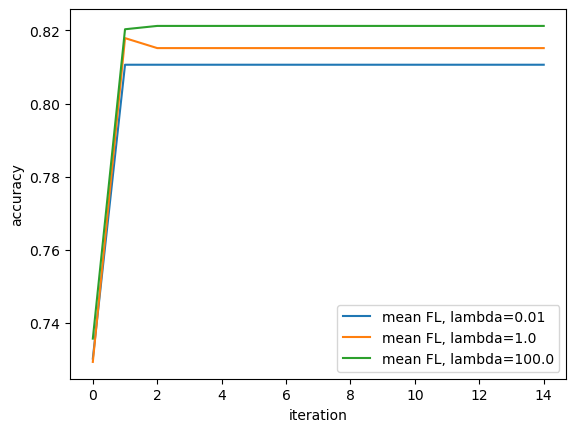

In [248]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for lambda_lasso in lambda_lassos[:4]:
    fl_mean_acc = np.mean(lambda_lasso_scores[lambda_lasso], axis=1)[:len(x)]
    plt.plot(x, fl_mean_acc, label='mean FL, lambda=' + str(lambda_lasso))

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("./data/non-parametric/sbm_mean_lambda.pdf", bbox_inches='tight')
plt.close()